<br>
<h2 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">FAISS Pytorch Inference</h2>
<br>

<h3>📌 Inference Pipeline is taken from this Notebook:</h3> <h4><a href='https://www.kaggle.com/ks2019/happywhale-arcface-baseline-tpu'>https://www.kaggle.com/ks2019/happywhale-arcface-baseline-tpu</a></h4>

<h3>📌 Train Notebook:</h3> <h4><a href='https://www.kaggle.com/debarshichanda/pytorch-arcface-gem-pooling-starter'>https://www.kaggle.com/debarshichanda/pytorch-arcface-gem-pooling-starter</a></h4>

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Install Required Libraries</h1></span>

In [3]:
!pip install timm
!pip install faiss-cpu

ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Import Required Libraries 📚</h1></span>

In [1]:
import os
import gc
import cv2
import math
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import StratifiedKFold

# For Image Models
import timm

# For Similarity Search
import faiss

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Configuration ⚙️</h1></span>

In [2]:
CONFIG = {"seed": 2024,
          "img_size": 128,
          "model_name": "tf_efficientnet_b0_ns",
          "num_classes": 10222,
          "embedding_size": 512,
          "train_batch_size": 2,
          "valid_batch_size": 2,
          "n_fold": 5,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          # ArcFace Hyperparameters
          "s": 30.0, 
          "m": 0.30,
          "ls_eps": 0.0,
          "easy_margin": False
          }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Set Seed for Reproducibility</h1></span>

In [3]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [4]:
ROOT_DIR = 'D:\\pet identification\\'
TRAIN_DIR = 'D:\\pet identification\\train'
TEST_DIR = 'D:\\pet identification\\test'

In [5]:
def get_train_file_path(id):
    return f"{TRAIN_DIR}\\{id}.jpg"

In [6]:
train_csv = pd.read_csv(f'{ROOT_DIR}/labels.csv')
print(train_csv.head())
print(len(train_csv))


                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
10222


# <h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Read the Data 📖</h1>

In [7]:
df = pd.read_csv(f"{ROOT_DIR}/labels.csv")
df['file_path'] = df['id'].apply(get_train_file_path)
df.head()

,id,breed,file_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,D:\pet identification\train\000bec180eb18c7604...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,D:\pet identification\train\001513dfcb2ffafc82...
2,001cdf01b096e06d78e9e5112d419397,pekinese,D:\pet identification\train\001cdf01b096e06d78...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,D:\pet identification\train\00214f311d5d2247d5...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,D:\pet identification\train\0021f9ceb3235effd7...


In [8]:
encoder = LabelEncoder()

# with open("../input/arcface-gap-embed/le.pkl", "rb") as fp:
#     encoder = joblib.load(fp)
encoder.fit(df['id'])
    
df['individual_id'] = encoder.transform(df['id'])
df.head()

,id,breed,file_path,individual_id
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,D:\pet identification\train\000bec180eb18c7604...,0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,D:\pet identification\train\001513dfcb2ffafc82...,1
2,001cdf01b096e06d78e9e5112d419397,pekinese,D:\pet identification\train\001cdf01b096e06d78...,2
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,D:\pet identification\train\00214f311d5d2247d5...,3
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,D:\pet identification\train\0021f9ceb3235effd7...,4


In [9]:
encoder2 = LabelEncoder()

# with open("../input/arcface-gap-embed/le.pkl", "rb") as fp:
#     encoder = joblib.load(fp)
encoder2.fit(df['breed'])
    
df['breed'] = encoder2.transform(df['breed'])
df.head()

,id,breed,file_path,individual_id
0,000bec180eb18c7604dcecc8fe0dba07,19,D:\pet identification\train\000bec180eb18c7604...,0
1,001513dfcb2ffafc82cccf4d8bbaba97,37,D:\pet identification\train\001513dfcb2ffafc82...,1
2,001cdf01b096e06d78e9e5112d419397,85,D:\pet identification\train\001cdf01b096e06d78...,2
3,00214f311d5d2247d5dfe4fe24b2303d,15,D:\pet identification\train\00214f311d5d2247d5...,3
4,0021f9ceb3235effd7fcde7f7538ed62,49,D:\pet identification\train\0021f9ceb3235effd7...,4


In [10]:
# skf = StratifiedKFold(n_splits=CONFIG['n_fold'])

# for fold, ( _, val_) in enumerate(skf.split(X=df, y=df.individual_id)):
#       df.loc[val_ , "kfold"] = fold

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [11]:
class HappyWhaleDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.ids = df['id'].values
        self.file_names = df['file_path'].values
        self.labels = df['individual_id'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        idx = self.ids[index]
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.labels[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'label': torch.tensor(label, dtype=torch.long),
            'id': idx
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [12]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [13]:
# NOT USED

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">ArcFace</h1></span>

In [14]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, 
                 m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=CONFIG['device'])
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Model</h1></span>

In [77]:
CONFIG = {"seed": 2022,
          "epochs": 4,
          "img_size": 448,
          "model_name": "efficientnet_b0",
          "num_class": 120,
          "embedding_size": 512,
          "train_batch_size":16,
          "valid_batch_size": 16,
          "learning_rate": 1e-4,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 5,
          "n_accumulate": 1,
          "device": "cpu",
          # ArcFace Hyperparameters
          "s": 30.0, 
          "m": 0.50,
          "ls_eps": 0.0,
          "easy_margin": False
          }

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, 
                 m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=CONFIG['device'])
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output
class DogImageModel(nn.Module):
    def __init__(self, model_name, embedding_size, pretrained=True):
        super(DogImageModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.embedding = nn.Linear(in_features, embedding_size)
        self.fc = ArcMarginProduct(embedding_size, 
                                   120,
                                   s=CONFIG["s"], 
                                   m=CONFIG["m"], 
                                   easy_margin=CONFIG["ls_eps"], 
                                   ls_eps=CONFIG["ls_eps"])

    def forward(self, images, labels):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        embedding = self.embedding(pooled_features)
        output = self.fc(embedding, labels)
        return output
    
    def extract(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        embedding = self.embedding(pooled_features)
        return embedding


model = DogImageModel(CONFIG['model_name'], CONFIG['embedding_size'])
model.load_state_dict(torch.load("D:\pet identification\Pet-Identification\Loss6.1719_epoch8.bin"))
model.to(CONFIG['device']);

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b0.ra_in1k)
INFO:timm.models._hub:[timm/efficientnet_b0.ra_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [51]:
torch.save(model.state_dict(), "D:\\pet identification\\Pet-Identification\\weight_changed.pkt")

In [52]:
@torch.inference_mode()
def get_embeddings(model, dataloader, device):
    model.eval()
    
    LABELS = []
    EMBEDS = []
    IDS = []
    print('start to get the embeddings')
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar: 
        # print(step)       
        images = data['image'].to(device, dtype=torch.float)
        labels = data['label'].to(device, dtype=torch.long)
        ids = data['id']

        outputs = model.extract(images)
        
        LABELS.append(labels.cpu().numpy())
        EMBEDS.append(outputs.cpu().numpy())
        IDS.append(ids)
    
    EMBEDS = np.vstack(EMBEDS)
    LABELS = np.concatenate(LABELS)
    IDS = np.concatenate(IDS)
    
    return EMBEDS, LABELS, IDS

In [53]:
size_of_dataset = len(df)
print(size_of_dataset)
ratio = 3 / 4
train_dataset = HappyWhaleDataset(df[0:int(size_of_dataset * ratio)], transforms=data_transforms["train"])
valid_dataset = HappyWhaleDataset(df[int(size_of_dataset * ratio):], transforms=data_transforms["valid"])

10222


In [54]:
train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=0, shuffle=False, pin_memory=False)
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=0, shuffle=False, pin_memory=False)


In [55]:
dic = train_dataset.__getitem__(0)
print(dic)

{'image': tensor([[[ 0.8447,  0.2111,  1.3755,  ...,  1.9407,  1.6495,  0.7933],
         [-0.0972,  1.5810,  1.2557,  ...,  1.2043,  1.6153,  1.5125],
         [ 0.4679,  0.3994,  0.5022,  ...,  0.8276,  1.0159,  1.4269],
         ...,
         [ 1.1358,  1.0673,  1.0159,  ...,  0.6049,  0.5193,  1.0331],
         [ 1.0502,  1.1358,  1.0844,  ...,  0.1426,  0.7762,  1.7009],
         [ 1.0159,  1.1529,  1.1358,  ...,  0.0569,  0.0741,  1.2728]],

        [[-0.0049, -0.4426,  0.8704,  ...,  1.5357,  1.3431,  0.3803],
         [-0.6877,  1.1155,  0.8004,  ...,  0.6254,  1.1681,  1.0630],
         [-0.1625, -0.2325, -0.1625,  ...,  0.0826,  0.5028,  0.9055],
         ...,
         [ 0.0476,  0.0826,  0.1001,  ..., -0.4426, -0.4776,  0.2752],
         [ 0.0301,  0.1352,  0.1527,  ..., -0.9328, -0.0049,  0.9230],
         [-0.0049,  0.1527,  0.1877,  ..., -1.1429, -0.9503,  0.5028]],

        [[-0.6018, -1.1421, -0.0267,  ...,  0.4614, -0.3230, -0.7761],
         [-1.0724,  0.6705,  0.2696

torch.Size([3, 128, 128])
000bec180eb18c7604dcecc8fe0dba07


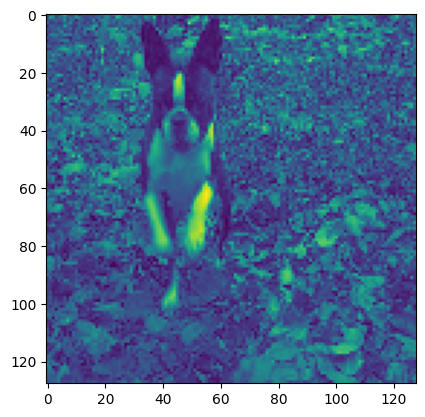

In [82]:
import matplotlib.pyplot as plt 
imgs = dic['image']
print(imgs.shape)
plt.imshow(imgs[2])
plt.plot()
print(dic['id'])

In [57]:
print(CONFIG['device'])
train_embeds, train_labels, train_ids = get_embeddings(model, train_loader, CONFIG['device'])
valid_embeds, valid_labels, valid_ids = get_embeddings(model, valid_loader, CONFIG['device'])

cpu
start to get the embeddings


100%|██████████| 480/480 [01:36<00:00,  4.98it/s]


start to get the embeddings


100%|██████████| 160/160 [00:32<00:00,  4.94it/s]


In [58]:
train_embeds = normalize(train_embeds, axis=1, norm='l2')
valid_embeds = normalize(valid_embeds, axis=1, norm='l2')

In [59]:
train_labels = encoder.inverse_transform(train_labels)
valid_labels = encoder.inverse_transform(valid_labels)

In [60]:
index = faiss.IndexFlatIP(CONFIG['embedding_size'])
index.add(train_embeds)

In [61]:
D, I = index.search(valid_embeds, k=50)

In [37]:
allowed_targets = np.unique(train_labels)

In [38]:
val_targets_df = pd.DataFrame(np.stack([valid_ids, valid_labels], axis=1), columns=['image','target'])
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets), 'target'] = 'new_individual'
val_targets_df.target.value_counts()

target
new_individual    2556
Name: count, dtype: int64

In [63]:
valid_df = []
for i, val_id in tqdm(enumerate(valid_ids)):
    targets = train_labels[I[i]]
    distances = D[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = val_id
    valid_df.append(subset_preds)

2556it [00:00, 3343.69it/s]


In [64]:
valid_df = pd.concat(valid_df).reset_index(drop=True)
valid_df = valid_df.groupby(['image','target']).distances.max().reset_index()
valid_df.head()

,image,target,distances
0,bffc7036e3c90a13e85e540837dfa9df,01680178ca6664294efb493a46014a82,0.650147
1,bffc7036e3c90a13e85e540837dfa9df,0581b47e4c3890fb74a5485aa4d008f0,0.612284
2,bffc7036e3c90a13e85e540837dfa9df,08ed3bf636ad906f5ddea9ebda22ff98,0.657146
3,bffc7036e3c90a13e85e540837dfa9df,0a77b9015c37f39c92b5399dc29da97c,0.698753
4,bffc7036e3c90a13e85e540837dfa9df,13b5f36cb39cb5123958c6e4fbfd5399,0.648122


In [65]:
print(valid_df['image'][0])

print(valid_df['target'][0])

print(valid_df['distances'][0])


bffc7036e3c90a13e85e540837dfa9df
01680178ca6664294efb493a46014a82
0.6501470804214478


D:\pet identification\train\bffc7036e3c90a13e85e540837dfa9df.jpg


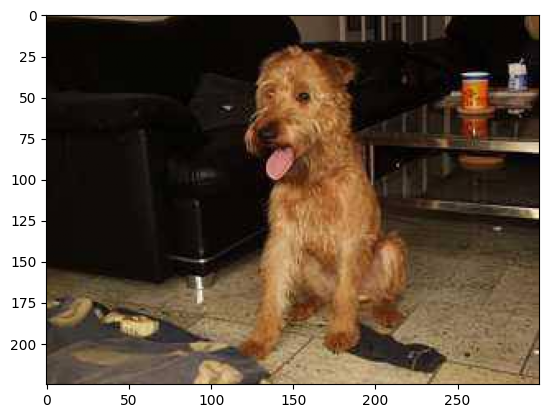

In [76]:
path_train = get_train_file_path(valid_df['image'][0])
print(path_train)
imgs = cv2.imread(path_train)[:, :, ::-1] / 255.0
plt.imshow(imgs)

D:\pet identification\train\01680178ca6664294efb493a46014a82.jpg


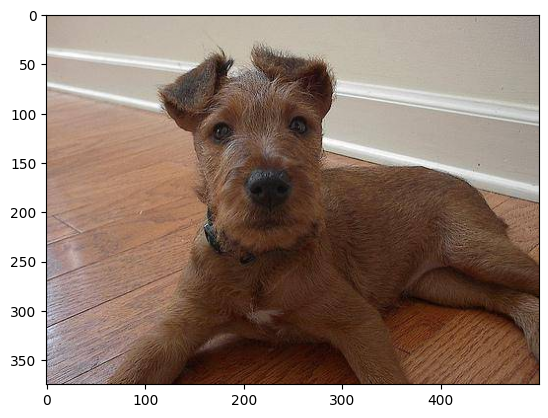

In [75]:
path_train = get_train_file_path(valid_df['target'][0])
print(path_train)
imgs = cv2.imread(path_train)[:, :, ::-1] / 255.0
plt.imshow(imgs)

D:\pet identification\train\01680178ca6664294efb493a46014a82.jpg
D:\pet identification\train\0581b47e4c3890fb74a5485aa4d008f0.jpg
D:\pet identification\train\08ed3bf636ad906f5ddea9ebda22ff98.jpg
D:\pet identification\train\0a77b9015c37f39c92b5399dc29da97c.jpg
D:\pet identification\train\13b5f36cb39cb5123958c6e4fbfd5399.jpg


[]

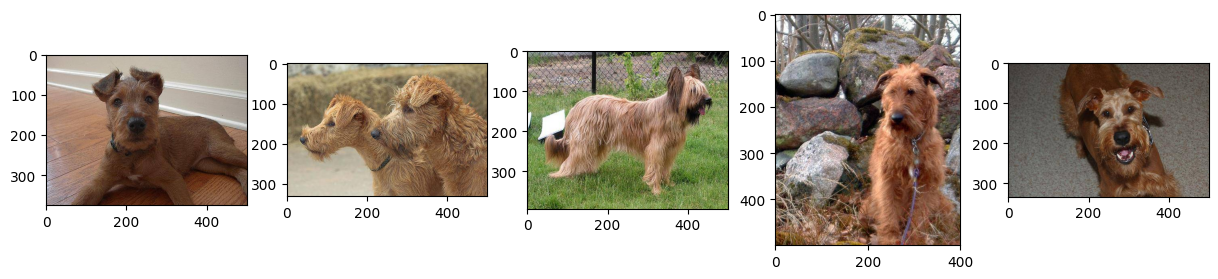

In [74]:
num_imgs = 5
fig, axs = plt.subplots(1, num_imgs, figsize=(num_imgs * 3, 3))
for i in range(num_imgs):
    path_train = get_train_file_path(valid_df['target'][i])
    print(path_train)
    imgs = cv2.imread(path_train)[:, :, ::-1] / 255.0
    axs[i].imshow(imgs)
plt.plot()

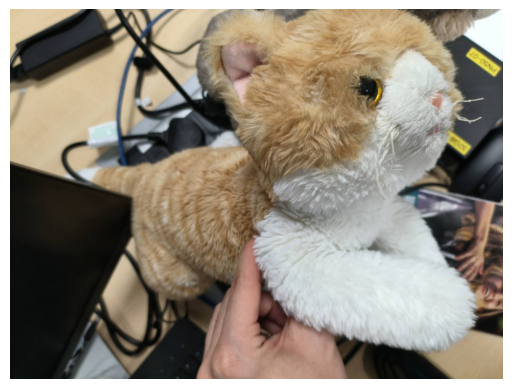

In [72]:
import cv2
import matplotlib.pyplot as plt

# Paths to the images
c1 = "D:/pet identification/Pet-Identification/c1.jpg"
c2 = "D:/pet identification/Pet-Identification/c2.jpg"
d1 = "D:/pet identification/Pet-Identification/d1.jpg"
d2 = "D:/pet identification/Pet-Identification/d2.jpg"

# Read and process the images
vc1 = cv2.imread(c1)[:, :, ::-1] / 255.0  # Convert BGR to RGB and scale to [0, 1]
vc2 = cv2.imread(c2)[:, :, ::-1] / 255.0  # Convert BGR to RGB and scale to [0, 1]
vd1 = cv2.imread(d1)[:, :, ::-1] / 255.0  # Convert BGR to RGB and scale to [0, 1]
vd2 = cv2.imread(d2)[:, :, ::-1] / 255.0  # Convert BGR to RGB and scale to [0, 1]

# Display the image using matplotlib
plt.imshow(vc1)
plt.axis('off')  # Optional: Hide the axis
plt.show()

In [34]:
valid_df = valid_df.sort_values('distances', ascending=False).reset_index(drop=True)
valid_df.to_csv('val_neighbors.csv')

In [35]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [37]:
def get_predictions(test_df, threshold=0.2):
    predictions = {}
    for i, row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image]) == 5:
                continue
            predictions[row.image].append(row.target)
        elif row.distances > threshold:
            predictions[row.image] = [row.target, 'new_individual']
        else:
            predictions[row.image] = ['new_individual', row.target]

    for x in tqdm(predictions):
        if len(predictions[x]) < 5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x] + remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

In [38]:
def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Compute CV</h1></span>

In [39]:
best_th = 0
best_cv = 0
for th in [0.1*x for x in range(11)]:
    all_preds = get_predictions(valid_df, threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target, preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv > best_cv:
        best_th = th
        best_cv = cv

127800it [00:02, 46742.17it/s]
100%|██████████| 2556/2556 [00:00<?, ?it/s]


CV at threshold 0.0: 0.5


127800it [00:02, 45369.47it/s]
100%|██████████| 2556/2556 [00:00<?, ?it/s]


CV at threshold 0.1: 0.5


127800it [00:02, 47308.03it/s]
100%|██████████| 2556/2556 [00:00<?, ?it/s]


CV at threshold 0.2: 0.5


127800it [00:02, 46075.67it/s]
100%|██████████| 2556/2556 [00:00<?, ?it/s]


CV at threshold 0.30000000000000004: 0.5


127800it [00:02, 47126.43it/s]
100%|██████████| 2556/2556 [00:00<?, ?it/s]


CV at threshold 0.4: 0.5011737089201878


127800it [00:02, 47184.27it/s]
100%|██████████| 2556/2556 [00:00<00:00, 339819.99it/s]


CV at threshold 0.5: 0.5072378716744914


127800it [00:02, 46774.23it/s]
100%|██████████| 2556/2556 [00:00<00:00, 2465081.86it/s]


CV at threshold 0.6000000000000001: 0.5408841940532081


127800it [00:02, 47342.58it/s]
100%|██████████| 2556/2556 [00:00<?, ?it/s]


CV at threshold 0.7000000000000001: 0.6463223787167449


127800it [00:02, 47647.70it/s]
100%|██████████| 2556/2556 [00:00<00:00, 163559.04it/s]


CV at threshold 0.8: 0.8478090766823161


127800it [00:02, 47120.49it/s]
100%|██████████| 2556/2556 [00:00<?, ?it/s]


CV at threshold 0.9: 0.99197965571205


127800it [00:02, 47428.67it/s]
100%|██████████| 2556/2556 [00:00<?, ?it/s]


CV at threshold 1.0: 0.9996087636932708


In [40]:
print("Best threshold", best_th)
print("Best cv", best_cv)
val_targets_df.describe()

Best threshold 1.0
Best cv 0.9996087636932708


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
count,2556.0,2556.0,2556.0,2556.0,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000
mean,0.5,0.5,0.5,0.5,0.501174,0.507238,0.540884,0.646322,0.847809,0.991980,0.999609
std,0.0,0.0,0.0,0.0,0.024201,0.059732,0.137033,0.227533,0.230118,0.062828,0.013984
min,0.5,0.5,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
25%,0.5,0.5,0.5,0.5,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000
50%,0.5,0.5,0.5,0.5,0.500000,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000
75%,0.5,0.5,0.5,0.5,0.500000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000
max,0.5,0.5,0.5,0.5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] = val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

{True: 2556}


TypeError: agg function failed [how->mean,dtype->object]

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Inference</h1></span>

In [42]:
train_embeds = np.concatenate([train_embeds, valid_embeds])
train_labels = np.concatenate([train_labels, valid_labels])
print(train_embeds.shape,train_labels.shape)

(10222, 512) (10222,)


In [43]:
index = faiss.IndexFlatIP(CONFIG['embedding_size'])
index.add(train_embeds)

In [44]:
test = pd.DataFrame()
test["image"] = os.listdir("../input/happy-whale-and-dolphin/test_images")
test["file_path"] = test["image"].apply(lambda x: f"{TEST_DIR}/{x}")
test["individual_id"] = -1  #dummy value
test.head()

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: '../input/happy-whale-and-dolphin/test_images'

In [45]:
test_dataset = HappyWhaleDataset(test, transforms=data_transforms["valid"])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], 
                         num_workers=2, shuffle=False, pin_memory=True)

KeyError: 'id'

In [46]:
test_embeds, _, test_ids = get_embeddings(model, test_loader, CONFIG['device'])
test_embeds = normalize(test_embeds, axis=1, norm='l2')

NameError: name 'test_loader' is not defined

In [39]:
D, I = index.search(test_embeds, k=50)

In [40]:
test_df = []
for i, test_id in tqdm(enumerate(test_ids)):
    targets = train_labels[I[i]]
    distances = D[i]
    subset_preds = pd.DataFrame(np.stack([targets, distances], axis=1), columns=['target','distances'])
    subset_preds['image'] = test_id
    test_df.append(subset_preds)
    
test_df = pd.concat(test_df).reset_index(drop=True)
test_df = test_df.groupby(['image','target']).distances.max().reset_index()
test_df = test_df.sort_values('distances', ascending=False).reset_index(drop=True)
test_df.to_csv('test_neighbors.csv')

27956it [00:21, 1329.71it/s]


In [41]:
predictions = get_predictions(test_df, best_threshold_adjusted)

predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions['predictions'] = predictions['predictions'].apply(lambda x: ' '.join(x))
predictions.to_csv('submission.csv',index=False)
predictions.head()

1007274it [01:02, 16168.20it/s]
100%|██████████| 27956/27956 [00:00<00:00, 1129894.80it/s]


,image,predictions
0,5c9e04a6e6a9a2.jpg,547afd43d437 new_individual c295e46e85d8 9a3ee...
1,a3a9c424ef9f06.jpg,0ed88187dcb5 new_individual e44e4b2ceed9 3acf1...
2,dd806b5d0f42e1.jpg,13e453fd9598 new_individual 06b287d73a9f da961...
3,50df0a954eb94c.jpg,713eb1a00c3d new_individual f664abace56d 7a36f...
4,3c52966f74d2ad.jpg,978520860ceb new_individual c85db2d6613b 4c05c...
